In [1]:
import os
import torch

import matplotlib.pyplot as plt


pemp_losses = {}
pemp1_losses = {}
cnmp_losses = {}

data_plot_id = 2
ys = {}
best_cnmps = {}
best_pemps = {}
best_pemp1s = {}

num_samples = 250_000

for i in range(1, 5):
    folders = f'../outputs/comparison/{i}_peak/no_pos/8_2_64_64/bs_1/'
    l, l1, lcnmp = [], [], []
    for j, folder in enumerate(os.listdir(folders)):
        folder_path = os.path.join(folders, folder)
        try:
            tl = torch.tensor(torch.load(f'{folder_path}/losses.pt'))
            tl1 = torch.tensor(torch.load(f'{folder_path}/losses1.pt'))
            tlcnmp = torch.tensor(torch.load(f'{folder_path}/losses_cnmp.pt'))

            if j == data_plot_id:
                ys[i] = torch.tensor(torch.load(f'{folder_path}/y.pt'))
                best_cnmps[i] = torch.tensor(torch.load(f'{folder_path}/cnmp.pt'))
                best_pemps[i] = torch.tensor(torch.load(f'{folder_path}/pemp.pt'))
                best_pemp1s[i] = torch.tensor(torch.load(f'{folder_path}/pemp1.pt'))
            tl_ids = (torch.linspace(0, len(tl)-1, num_samples)).long()
            tl1_ids = (torch.linspace(0, len(tl1)-1, num_samples)).long()
            tlcnmp_ids = (torch.linspace(0, len(tlcnmp)-1, num_samples)).long()

            l.append(tl[tl_ids])
            l1.append(tl1[tl1_ids])
            lcnmp.append(tlcnmp[tlcnmp_ids])
        except:
            continue
        
    pemp_losses[i] = torch.mean(torch.stack(l), dim=0)
    pemp1_losses[i] = torch.mean(torch.stack(l1), dim=0)
    cnmp_losses[i] = torch.mean(torch.stack(lcnmp), dim=0)


/tmp/ipykernel_6199/4150517254.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys[i] = torch.tensor(torch.load(f'{folder_path}/y.pt'))


In [2]:
def moving_avg(tl, window_size=100):
    weights = torch.full((window_size,), 1.0 / window_size, dtype=tl.dtype, device=tl.device)

    # convolution for sliding window
    t = torch.nn.functional.conv1d(
        tl.unsqueeze(0).unsqueeze(0),
        weights.unsqueeze(0).unsqueeze(0),
        padding='same'
    ).squeeze(0).squeeze(0)

    # first and last few elements
    t[:window_size // 2] = torch.cumsum(tl[:window_size // 2], dim=0) / torch.arange(1, window_size // 2 + 1, device=tl.device)
    t[-window_size // 2:] = torch.flip(torch.cumsum(torch.flip(tl[-window_size // 2:], dims=[0]), dim=0), dims=[0]) / torch.arange(window_size // 2, 0, -1, device=tl.device)

    return t


filter_size = 1000
samples = 10000
for i in range(1, 5):
    l0 = moving_avg(pemp_losses[i], filter_size)
    l1 = moving_avg(pemp1_losses[i], filter_size)
    l2 = moving_avg(cnmp_losses[i], filter_size)

    pemp_losses[i] = l0[torch.linspace(0, len(l0)-1, samples).long()]
    pemp1_losses[i] = l1[torch.linspace(0, len(l0)-1, samples).long()]
    cnmp_losses[i] = l2[torch.linspace(0, len(l0)-1, samples).long()]


/tmp/ipykernel_6199/1340994524.py:5: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  t = torch.nn.functional.conv1d(


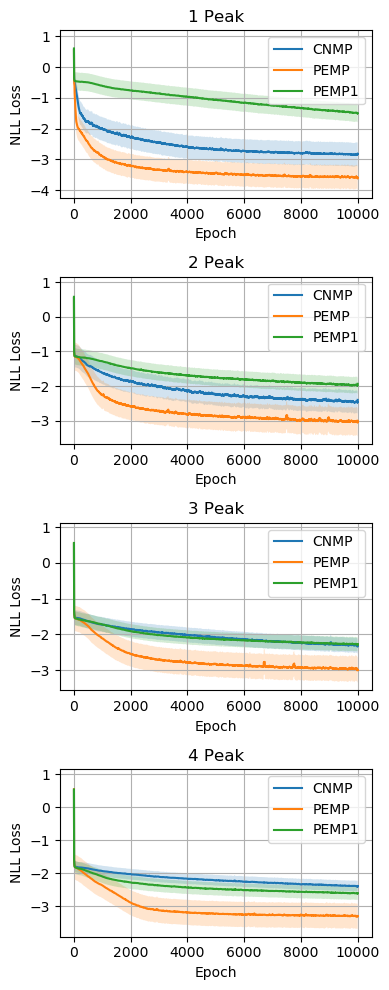

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(4, 10))

x = torch.arange(samples-1)

for i in range(1, 5):
    axs[i-1].plot(x, cnmp_losses[i][:-1].numpy(), label=f'CNMP')
    axs[i-1].plot(x, pemp_losses[i][:-1].numpy(), label=f'PEMP')
    axs[i-1].plot(x, pemp1_losses[i][:-1].numpy(), label=f'PEMP1')

    # add std as shaded area
    axs[i-1].fill_between(x, cnmp_losses[i][:-1].numpy() - cnmp_losses[i][:-1].std().numpy(), cnmp_losses[i][:-1].numpy() + cnmp_losses[i][:-1].std().numpy(), alpha=0.2)
    axs[i-1].fill_between(x, pemp_losses[i][:-1].numpy() - pemp_losses[i][:-1].std().numpy(), pemp_losses[i][:-1].numpy() + pemp_losses[i][:-1].std().numpy(), alpha=0.2)
    axs[i-1].fill_between(x, pemp1_losses[i][:-1].numpy() - pemp1_losses[i][:-1].std().numpy(), pemp1_losses[i][:-1].numpy() + pemp1_losses[i][:-1].std().numpy(), alpha=0.2)

    axs[i-1].legend()
    axs[i-1].set_title(f'{i} Peak')
    axs[i-1].set_xlabel('Epoch')
    axs[i-1].set_ylabel('NLL Loss')
    axs[i-1].grid()
fig.tight_layout()
plt.show()

In [ ]:
# # compute trajectories produced by cnmp, pemp, pemp1
# import sys

# folder_path = '../models/'
# if folder_path not in sys.path:
#     sys.path.append(folder_path)

# folder_path = '../data/'
# if folder_path not in sys.path:
#     sys.path.append(folder_path)

# from pemp import PEMP
# from cnmp import CNMP

# from data_generators import *
# from positional_encoders import *
# from plotters import *

# device = 'cpu'
# t_steps = 200
# dx, dy, dg, dpe = 1, 1, 0, 10
# num_demos, num_val = 8, 2
# num_trajs = num_demos + num_val
# t_steps = 200
# n_max, m_max = 10, 10
# num_peaks = 3
# batch_size = 1

# d_model = dpe
# pe_code = 0
# pe = pes[pe_code]() / d_model

# pe_code = 1
# pe1 = pes[pe_code]() / d_model

# dpe_aug = dpe + dg  # dg for gamma (peak_positions)
# dpe_aug_cnmp = dx + dg

# val_obs = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
# val_obs1 = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
# val_obs_cnmp = torch.zeros((batch_size, n_max, dpe_aug_cnmp+dy), dtype=torch.float32, device=device)
# val_tar_x = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)
# val_tar_x1 = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)
# val_tar_x_cnmp = torch.zeros((batch_size, t_steps, dpe_aug_cnmp), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
# val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

# def prepare_masked_val_batch(t: list, traj_ids: list, fixed_ind=None):
#     val_obs.fill_(0)
#     val_tar_x.fill_(0)
#     val_tar_y.fill_(0)
#     val_obs_mask.fill_(False)

#     val_obs_cnmp.fill_(0)
#     val_tar_x_cnmp.fill_(0)

#     val_obs1.fill_(0)
#     val_tar_x1.fill_(0)

#     for i, traj_id in enumerate(traj_ids):
#         traj = t[traj_id]

#         n = num_peaks #torch.randint(5, n_max, (1,)).item()

#         permuted_ids = torch.randperm(t_steps)
#         n_ids = permuted_ids[:n]
#         m_ids = torch.arange(t_steps)
#         if fixed_ind != None:
#             for p in range(n):
#                 n_ids[p] = fixed_ind[i, p]
#             # n_ids[-1] = fixed_ind[i]
        
#         val_obs[i, :n, :dpe] = pe[n_ids]
#         val_obs[i, :n, dpe_aug:] = traj[n_ids]
#         val_obs_mask[i, :n] = True

#         val_obs1[i, :n, :dpe] = pe1[n_ids]
#         val_obs1[i, :n, dpe_aug:] = traj[n_ids]
        
#         val_tar_x[i, :, :dpe] = pe
#         val_tar_y[i] = traj[m_ids]

#         val_tar_x1[i, :, :dpe] = pe1

#         val_obs_cnmp[i, :n, :dx] = x_train[traj_id, n_ids]
#         val_obs_cnmp[i, :n, dpe_aug_cnmp:] = traj[n_ids]

#         val_tar_x_cnmp[i, :, :dx] = x_train[traj_id]

# test_traj = 0

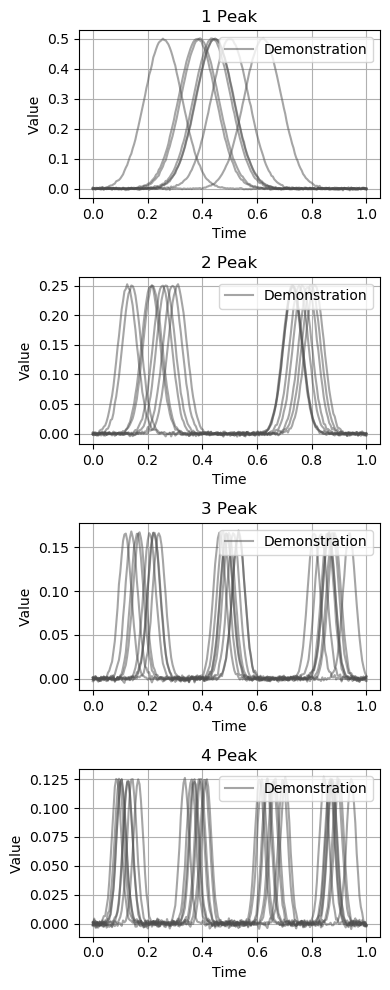

In [8]:
# plotting the data in 4x1 figure
# y is a dictionary with keys 1, 2, 3, 4
# y[i] is a tensor of 8x200x1


x = torch.linspace(0, 1, 200)
fig, axs = plt.subplots(4, 1, figsize=(4, 10))

for i in range(1, 5):
    for j in range(8):
        lbl = 'Demonstration' if j == 0 else None
        axs[i-1].plot(x, ys[i][j].squeeze().numpy(), label=lbl, alpha=0.5, color='#4d4d4d')

    axs[i-1].set_title(f'{i} Peak')
    axs[i-1].set_xlabel('Time')
    axs[i-1].set_ylabel('Value')
    axs[i-1].grid()
    axs[i-1].legend(loc='upper right')

fig.tight_layout()
plt.show()